/home/kd/Desktop/proj/apr/speech_pa/speech_utils.py:10: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")
/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/datasets/load.py:759: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Loading dataset from disk:   0%|          | 0/24 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/24 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/24 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/24 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/24 [00:00<?, ?it/s]

11
4
8
3
4
Train+Valid Data Splits - ['/mnt/sea/speech/processed_datasets/Common_Voice_16_1_pa-IN_ASR__train', '/mnt/sea/speech/processed_datasets/Common_Voice_16_1_pa-IN_ASR__validation', '/mnt/sea/speech/processed_datasets/fleurs_pa_ASR__train', '/mnt/sea/speech/processed_datasets/fleurs_pa_ASR__valid', '/mnt/sea/speech/processed_datasets/Indicvoice_pa_ASR__train', '/mnt/sea/speech/processed_datasets/Indicvoice_pa_ASR__valid', '/mnt/sea/speech/processed_datasets/PunjabiSpeech_A_labeled_Speech_Corpus_ASR__train', '/mnt/sea/speech/processed_datasets/PunjabiSpeech_A_labeled_Speech_Corpus_ASR__valid']

Test data splits - ['/mnt/sea/speech/processed_datasets/Common_Voice_16_1_pa-IN_ASR__test', '/mnt/sea/speech/processed_datasets/fleurs_pa_ASR__test', '/mnt/sea/speech/processed_datasets/PunjabiSpeech_A_labeled_Speech_Corpus_ASR__test']
Dataset({
    features: ['speaker_id', 'audio', 'text', 'gender', 'duration'],
    num_rows: 22036
})
Dataset({
    features: ['speaker_id', 'audio', 'text'

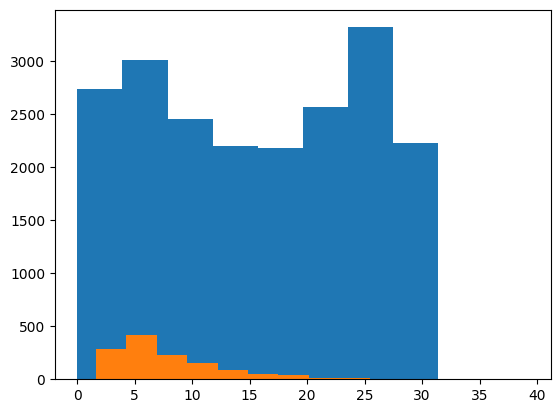

In [1]:
import faulthandler
faulthandler.enable()


from datasets import load_from_disk, concatenate_datasets, DatasetDict
import IPython.display as ipd
import speech_utils as su
import random
import numpy as np
from transformers import Wav2Vec2CTCTokenizer
from transformers import SeamlessM4TFeatureExtractor
from transformers import Wav2Vec2BertProcessor
from transformers import Wav2Vec2BertForCTC
from transformers import TrainingArguments
from transformers import Trainer
from functools import partial

import numpy as np
import random
import torch
from datasets import load_metric

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
from  data_collator import DataCollatorCTCWithPadding

import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'train_w2v-bert.ipynb'

datasets_dirs = [
    '/mnt/sea/speech/processed_datasets/CMU_Synth_ASR',
      '/mnt/sea/speech/processed_datasets/Common_Voice_16_1_pa-IN_ASR', 
      '/mnt/sea/speech/processed_datasets/fleurs_pa_ASR',
      '/mnt/sea/speech/processed_datasets/Google_Synth_ASR',
       '/mnt/sea/speech/ds_filtered/indicsuperb_pa_ASR_filtered', 
       '/mnt/sea/speech/processed_datasets/Indicvoice_pa_ASR',
       '/mnt/sea/speech/processed_datasets/PunjabiSpeech_A_labeled_Speech_Corpus_ASR',
        '/mnt/sea/speech/ds_filtered/shrutilipi_pa_ASR_filtered' 
]

datasets = [load_from_disk(f'{d}') for d in datasets_dirs]

all_data_splits = []
train_data_splits = []
train_valid_data_splits = []
test_data_splits = []
valid_data_splits = []

train_md = []
test_md = []

for i, d in enumerate(datasets):
    for split in d:
        all_data_splits.append(d[split])
        if split == 'train':
            train_data_splits.append(d[split])
        if split == 'train' or 'valid' in split:
            train_valid_data_splits.append(d[split])
            train_md.append(datasets_dirs[i] + '__' + split)
        if split == 'test':
            test_data_splits.append(d[split])
            test_md.append(datasets_dirs[i] + '__' + split)
        if 'valid' in split:
            valid_data_splits.append(d[split])

print(len(all_data_splits))
print(len(train_data_splits))
print(len(train_valid_data_splits))
print(len(test_data_splits))
print(len(valid_data_splits))

print(f'Train+Valid Data Splits - {train_md}')
print()
print(f'Test data splits - {test_md}')

ds_all = concatenate_datasets(all_data_splits)
ds_train = concatenate_datasets(train_data_splits)
if len(train_valid_data_splits) > 0:
    ds_train_valid = concatenate_datasets(train_valid_data_splits)
else:
    ds_train_valid = None
if len(test_data_splits) > 0:
    ds_test = concatenate_datasets(test_data_splits)
else:
    ds_test = None
if len(valid_data_splits) > 0:
    ds_valid = concatenate_datasets(valid_data_splits)
else:
    ds_valid = None

print(ds_all)
print(ds_train)
print(ds_train_valid)
print(ds_test)
print(ds_valid)

ds = DatasetDict({
    'train': ds_train_valid,
    'test': ds_test,
})

# for trying training on single dataset source
# ds = load_from_disk('/mnt/sea/speech/processed_datasets/shrutilipi_pa_ASR')
su.get_summary(ds)

In [2]:
# if train and valid splits are there - change name of valid split to test

if 'noisy_test' in ds.column_names:
    train = concatenate_datasets([ds['train'], ds['valid']])
    test = concatenate_datasets([ds['test'], ds['test_known'], ds['noisy_test'], ds['noisy_test_known']])
    ds = DatasetDict({'train': train, 'test': test})

if 'valid' in ds.column_names and 'test' not in ds.column_names:
    ds['test'] = ds['valid']
    del ds['valid']

# split ['train'] to ['train', 'test']
if 'test' not in ds.column_names:
    ds = ds['train'].train_test_split(test_size=0.04, seed=42)
    print(ds)


In [3]:
ds_check = concatenate_datasets([ds['train'], ds['test']])
chars_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', ]
# chars_list = ['\u200b', '\u200c']
# su.check_sents_count(chars_list, ds_check)
su.check_sents_count_in_list(chars_list, ds_check,)

Count: 59


Removed 8 audio samples
Removed 0 audio samples
Removed 486 sentences
Removed 105 sentences
Removed 4 text samples
Removed 0 text samples
Dataset summary: 
DatasetDict({
    train: Dataset({
        features: ['speaker_id', 'audio', 'text', 'gender', 'duration', 'normalized_text'],
        num_rows: 20234
    })
    test: Dataset({
        features: ['speaker_id', 'audio', 'text', 'gender', 'duration', 'normalized_text'],
        num_rows: 1199
    })
})
train duration in hours: 87.06
test duration in hours: 2.48
Max duration: 29.9990625 seconds
Min duration: 0.1380625 seconds
Avg duration: 15.039072018879324 seconds

Max text length: 620 characters
Min text length: 2 characters
Avg text length: 161.65828395464936 characters



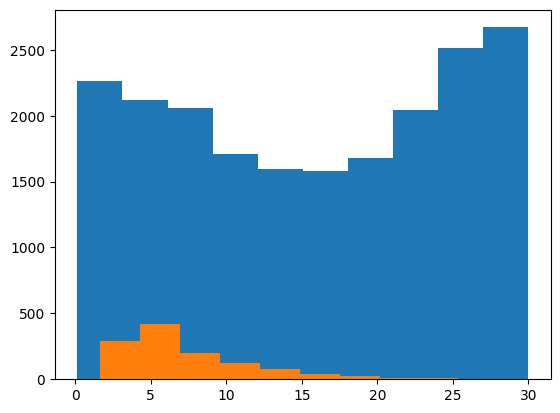

In [4]:
if 'valid' in ds.column_names:
    ds = su.merge_train_valid_splits(ds)

# this was required specifically for shrutilipi dataset because the loss starts diverging
# Since we will be using this on long form audios using split and stride, it's better to not add any silence
# ds = su.add_silence(ds)

ds['train'] = su.remove_audio_samples(ds['train'])
ds['test'] = su.remove_audio_samples(ds['test'])
ds = su.normalize_text_ds(ds)
ds['train'] = su.remove_text_samples(ds['train'], column_name='normalized_text')
ds['test'] = su.remove_text_samples(ds['test'], column_name='normalized_text')
su.get_summary(ds, text_column='normalized_text')


/tmp/ipykernel_332270/3458473224.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm(data):


  0%|          | 0/20234 [00:00<?, ?it/s]

 > Number of words: 31616


/tmp/ipykernel_332270/3458473224.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm(data):


  0%|          | 0/20234 [00:00<?, ?it/s]

 > Number of unique text lengths: 515
 > Number of sentences with length 1: 0
(0.9780625, 'ਅਗਲਾ')
(0.9970625, 'ਪੰਛੀ')
(0.5190625, 'ਅਗਲਾ')
(0.745, 'ਸਮਾਂ')
(0.504, 'ਜਾਓ')
(0.7620625, 'ਪੰਛੀ')
(0.8280625, 'ਰੁਕੋ')
(0.571, 'ਚਾਲ')
(0.751, 'ਨੌ')
(0.8170625, 'ਪਿੱਛੇ')
(0.754, 'ਚਾਰ')
(0.5240625, 'ਵਿਜ਼ੂਅਲ')
(0.6880625, 'ਛਾਲ ਮਾਰੋ')
(0.712, 'ਦੋ')
(0.4280625, 'ਸਮਾਂ')
(0.7050625, 'ਚਾਰ')
(0.7770625, 'ਸੱਤ')
(0.66, 'ਨੌ')
(0.544, 'ਬਿੱਲੀ')
(0.7290625, 'ਖੇਡੋ')
(0.5430625, 'ਹਾਂ')
(0.7750625, 'ਉੱਪਰ')
(0.5440625, 'ਛੱਡਣਾ')
(0.57, 'ਪਿੱਛੇ')
(0.711, 'ਨਾ')
(0.604, 'ਜ਼ੀਰੋ')
(0.44, 'ਤਿੰਨ')
(0.631, 'ਖੁਸ਼')
(0.902, 'ਬਿੱਲੀ')
(0.6180625, 'ਜਾਓ')
(0.521, 'ਸੱਤ')
(0.8840625, 'ਸਹਿਮਤ')
(0.8790625, 'ਥੱਲੇ')
(0.5890625, 'ਰੁਕੋ')
(0.843, 'ਅੱਗੇ')
(0.853, 'ਨਾ')
(0.8160625, 'ਅਸਹਿਮਤ')
(0.6180625, 'ਅਗਲਾ')
(0.4650625, 'ਹਾਂ')
(0.8420625, 'ਤਿੰਨ')
(0.771, 'ਅਗਲਾ')
(0.5030625, 'ਪਿੱਛੇ')
(0.81, 'ਸਿੱਖੋ')
(0.447, 'ਓਕੇ')
(0.863, 'ਜਾਓ')
(0.991, 'ਬਿਸਤਰਾ')
(0.574, 'ਜ਼ੀਰੋ')
(0.87, 'ਅਸਹਿਮਤ')
(0.4440625, 'ਹਾਂ')
(0.4250625, 'ਖੁਸ਼')
(0.544, 'ਦੋ')
(0.913, 

/tmp/ipykernel_332270/3458473224.py:93: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm(data):


  0%|          | 0/20234 [00:00<?, ?it/s]

Text(0.5, 1.0, 'audio length distribution')

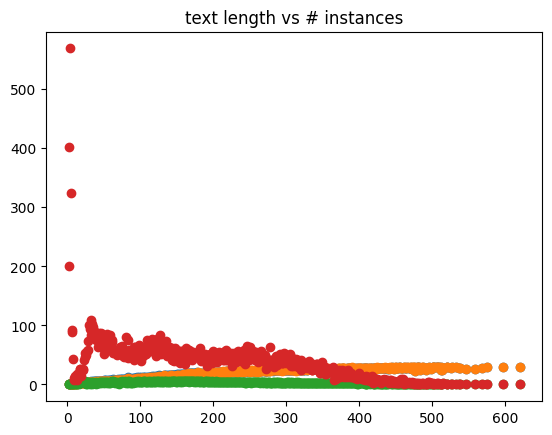

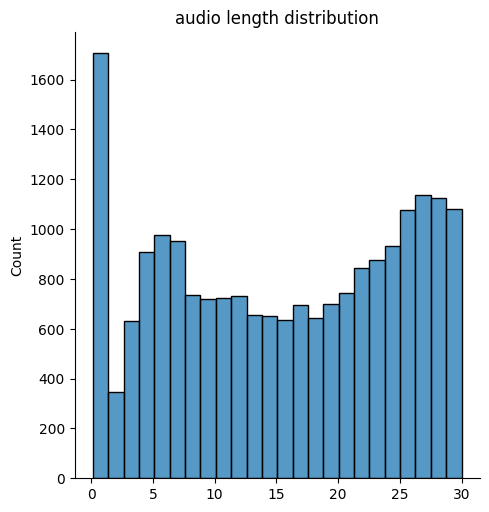

In [5]:
texts = ds['train']['normalized_text']
durations = ds['train']['duration']

import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from matplotlib import pylab as plt
%matplotlib inline
from collections import Counter
from scipy.stats import norm

data = []
for t, d in zip(texts, durations):
    data.append((d,t))

# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))


text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[0]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

print(" > Number of unique text lengths: {}".format(len(text_vs_avg)))

print(" > Number of sentences with length 1: {}".format(text_len_counter[1]))
for item in data:
    if item[0] <= 1:
        print(item)

sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[0]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)

mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print("Mean: ", mean)
print("Std: ", std)

dist = norm(mean, std)

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[0]
    sec_per_char = dur / len(text)
    pdf =norm.pdf(sec_per_char)
    if pdf < 0.39:
        #print(item)
        pass

dist = norm(mean, std)

plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

audio_lens = []
for item in tqdm(data):
    audio_len = item[0]
    audio_lens.append(audio_len)

sns.displot(audio_lens)
plt.title("audio length distribution")

In [6]:
import pandas as pd

def get_indexes_to_accept(ds, split_check):
    texts = ds[split_check]['normalized_text']
    durations = ds[split_check]['duration']

    text_lengths = [len(text) for text in texts]
    df = pd.DataFrame({
        'text_length': text_lengths,
        'audio_duration': durations
    })


    # Compute the IQR for text length
    Q1_text = df['text_length'].quantile(0.25)
    Q3_text = df['text_length'].quantile(0.75)
    IQR_text = Q3_text - Q1_text

    # Compute the IQR for mean audio duration
    Q1_audio = df['audio_duration'].quantile(0.25)
    Q3_audio = df['audio_duration'].quantile(0.75)
    IQR_audio = Q3_audio - Q1_audio

    # Define a condition for filtering out outliers in text length
    condition_text = (df['text_length'] >= (Q1_text - 1.5 * IQR_text)) & (df['text_length'] <= (Q3_text + 1.5 * IQR_text))

    # Define a condition for filtering out outliers in audio duration
    condition_audio = (df['audio_duration'] >= (Q1_audio - 1.5 * IQR_audio)) & (df['audio_duration'] <= (Q3_audio + 1.5 * IQR_audio))


    # get indexes where condition_length is True as int
    indexes_text = df[condition_text].index.tolist()
    # get indexes where condition_audio is True
    indexes_audio = df[condition_audio].index.to_list()
    # get indexes where condition_length is False
    indexes_text_false = df[~condition_text].index.to_list()
    # get indexes where condition_audio is False
    indexes_audio_false = df[~condition_audio].index.to_list()

    # print len summary
    print(len(text_lengths), len(durations))
    print(len(indexes_text), len(indexes_audio))
    print(len(indexes_text_false), len(indexes_audio_false))

    # check count of intersection of false indexes
    print('intersection of outlier indexes for text_length and audio duration')
    print(len(set(indexes_text_false) & set(indexes_audio_false)))

        
    indexes_to_reject = list(set(set(indexes_text_false).union(set(indexes_audio_false))))
    indexes_to_accept = list(set(range(len(texts))) - set(indexes_to_reject))
  
    print(f'len of indexes to accept: {len(indexes_to_accept)} and len of indexes to reject: {len(indexes_to_reject)}')
    return indexes_to_accept, indexes_to_reject


train_idx, train_idx_rej = get_indexes_to_accept(ds, 'train')
print('------------------------------------------')
test_idx, test_idx_rej = get_indexes_to_accept(ds, 'test')



20234 20234
20228 20234
6 0
intersection of outlier indexes for text_length and audio duration
0
len of indexes to accept: 20228 and len of indexes to reject: 6
------------------------------------------
1199 1199
1184 1146
15 53
intersection of outlier indexes for text_length and audio duration
11
len of indexes to accept: 1142 and len of indexes to reject: 57


In [7]:
ds['train'] = ds['train'].select(train_idx)
ds['test'] = ds['test'].select(test_idx)

In [8]:
ds

DatasetDict({
    train: Dataset({
        features: ['speaker_id', 'audio', 'text', 'gender', 'duration', 'normalized_text'],
        num_rows: 20228
    })
    test: Dataset({
        features: ['speaker_id', 'audio', 'text', 'gender', 'duration', 'normalized_text'],
        num_rows: 1142
    })
})

In [9]:
# Download noise samples
import subprocess
import wget
import glob
import tarfile
import librosa  
import soundfile as sf
import os

# Download and unzip the clean audio file.
noise_samples = '/mnt/sea/speech/noise_samples.zip'
if not os.path.exists(noise_samples):
    rirs_noises_url = 'https://www.openslr.org/resources/28/rirs_noises.zip'  
    rirs_noises_path = wget.download(rirs_noises_url, noise_samples)
    print(f"Dataset downloaded at: {rirs_noises_path}")
else:
    print("Zipfile already exists.")
    rirs_noises_path = noise_samples

Zipfile already exists.


In [10]:
from zipfile import ZipFile
noise_samples_ext = '/mnt/sea/speech/noise_samples'
if not os.path.exists(noise_samples_ext):
    try:
        with ZipFile(rirs_noises_path, "r") as zipObj:
            zipObj.extractall(noise_samples_ext)
            print("Extracting noise data complete")
        # Convert 8-channel audio files to mono-channel
        wav_list = glob.glob(noise_samples_ext + '/RIRS_NOISES/**/*.wav', recursive=True)
        for wav_path in wav_list:
            mono_wav_path = wav_path[:-4] + '_mono.wav'
            cmd = f"sox {wav_path} {mono_wav_path} remix 1"
            subprocess.call(cmd, shell=True)
        print("Finished converting the 8-channel noise data .wav files to mono-channel")
    except Exception as e:
        print("Not extracting. Extracted noise data might already exist.")
        print(e)
else: 
    print("Extracted noise data already exists. Proceed to the next step.")

# Let's create the following list of noise samples to better showcase the effect of SNR in synthesizing noisy audio files.
noise_sample_list = [
                    '/RIRS_NOISES/pointsource_noises/noise-free-sound-0057_mono.wav',
                    '/RIRS_NOISES/pointsource_noises/noise-free-sound-0113_mono.wav',
                    '/RIRS_NOISES/pointsource_noises/noise-free-sound-0232_mono.wav',
                    '/RIRS_NOISES/pointsource_noises/noise-free-sound-0532_mono.wav',
                    '/RIRS_NOISES/pointsource_noises/noise-free-sound-0533_mono.wav',
                    '/RIRS_NOISES/pointsource_noises/noise-free-sound-0603_mono.wav',
                    '/RIRS_NOISES/pointsource_noises/noise-free-sound-0605_mono.wav',
                   ]

# # display the noise samples
# for noise_sample in noise_sample_list:
#     file_path = noise_samples_ext + noise_sample
#     ipd.display(ipd.Audio(filename=file_path, rate=16000))

Extracted noise data already exists. Proceed to the next step.


In [11]:

type1 = '/mnt/sea/speech/noise_samples/RIRS_NOISES/pointsource_noises'
type2 = '/mnt/sea/speech/noise_samples/RIRS_NOISES/real_rirs_isotropic_noises'
list1 = []
list2 = []
for root, dirs, files in os.walk(type1):
    for file in files:
        if file.endswith("_mono.wav"):
            list1.append(os.path.join(root, file))
for root, dirs, files in os.walk(type2):
    for file in files:
        if file.endswith("_mono.wav"):
            list2.append(os.path.join(root, file))

print(f"Total number of noise samples in {type1}: {len(list1)} and {type2}: {len(list2)}")
# use 300 samples for list2 - because it's mostly very silent or in other words on noise
noise_sample_list = list1 + list2[:300]

Total number of noise samples in /mnt/sea/speech/noise_samples/RIRS_NOISES/pointsource_noises: 843 and /mnt/sea/speech/noise_samples/RIRS_NOISES/real_rirs_isotropic_noises: 417


In [12]:
# function to read audio
def audioread(path = None, audio_arr = None,sr = 16000, norm = True, start=0, stop=None):
    if path is None and audio_arr is None:
        raise ValueError("Either path or audio_arr should be provided")
    
    if path is not None:
        path = os.path.abspath(path)
        if not os.path.exists(path):
            raise ValueError("[{}] does not exist!".format(path))
        try:
            x, sr = sf.read(path, start=start, stop=stop)
        except RuntimeError:  # fix for sph pcm-embedded shortened v2
            print('WARNING: Audio type not supported')
    
    if audio_arr is not None:
        x = np.array(audio_arr)

    if len(x.shape) == 1:  # mono
        if norm:
            rms = (x ** 2).mean() ** 0.5
            if rms == 0:
               rms = 1
            scalar = 10 ** (-25 / 20) / (rms)
            x = x * scalar
        return x, sr
    else:  # multi-channel
        x = x.T
        x = x.sum(axis=0)/x.shape[0]
        if norm:
            rms = (x ** 2).mean() ** 0.5
            if rms == 0:
               rms = 1
            scalar = 10 ** (-25 / 20) / (rms)
            x = x * scalar
        return x, sr
    
# function to mix a clean speech with a noise sample at a specified SNR level
def snr_mixer(clean, noise, snr):
    # Normalizing to -25 dB FS
    rmsclean = (clean**2).mean()**0.5
    if rmsclean == 0:
       rmsclean = 1
    
    scalarclean = 10 ** (-25 / 20) / rmsclean
    clean = clean * scalarclean
    rmsclean = (clean**2).mean()**0.5

    rmsnoise = (noise**2).mean()**0.5
    if rmsnoise == 0:
       rmsnoise = 1
    
    scalarnoise = 10 ** (-25 / 20) /rmsnoise
    noise = noise * scalarnoise
    rmsnoise = (noise**2).mean()**0.5
    if rmsnoise == 0:
       rmsnoise = 1
    
    # Set the noise level for a given SNR
    noisescalar = np.sqrt(rmsclean / (10**(snr/20)) / rmsnoise)
    noisenewlevel = noise * noisescalar
    noisyspeech = clean + noisenewlevel
    return clean, noisenewlevel, noisyspeech

# Add zeros to a noise sample to make it of the same duration as the clean audio.
def concatenate_noise_sample(noise, fs, len_clean):
    silence_length = 0.5
    while len(noise) <= len_clean:
       noiseconcat = np.append(noise, np.zeros(int(fs*silence_length)))
       noise = np.append(noiseconcat, noise)

    if noise.size > len_clean:
       noise = noise[0:len_clean]

    return noise



In [13]:


c_size = len(ds['train'])-1 
n_size = len(noise_sample_list)-1 

idx_c = random.randint(0, c_size)
idx_n = random.randint(0, n_size)


# Now, let's mix the selected clean audio and noise sample at 0dB SNR.
SNRs = [40, 50]

SNR = random.choice(SNRs)
print(f"Selected clean audio index: {idx_c} {c_size} and noise sample index: {idx_n} {n_size} with SNR: {SNR} dB")
clean_audio_arr = ds['train'][idx_c]['audio']['array']
noise_sample_f_name = noise_sample_list[idx_n]

clean, fs = audioread(audio_arr=clean_audio_arr, sr=16000)
noise, n_fs = audioread(path=noise_sample_f_name)

if len(noise) > len(clean):
   noise = noise[0:len(clean)]
elif len(noise) < len(clean):
   noise = concatenate_noise_sample(noise, n_fs, clean.size)

clean_snr, noise_snr, noisy_snr = snr_mixer(clean=clean, noise=noise, snr=SNR)
print("Finished creating noisy file.\n******")

display(ipd.Audio(noisy_snr, rate=16000, autoplay=False))

Selected clean audio index: 14460 20227 and noise sample index: 681 1142 with SNR: 40 dB
Finished creating noisy file.
******


In [14]:
ds['train']

Dataset({
    features: ['speaker_id', 'audio', 'text', 'gender', 'duration', 'normalized_text'],
    num_rows: 20228
})

In [15]:
update_vocab = False

if update_vocab:
  def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

  vocab_train = ds['train'].map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=ds['train'].column_names)
  vocab_test = ds['test'].map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=ds['test'].column_names)

  vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))

  vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
  vocab_dict["|"] = vocab_dict[" "]
  del vocab_dict[" "]
  vocab_dict["[UNK]"] = len(vocab_dict)
  vocab_dict["[PAD]"] = len(vocab_dict)
  len(vocab_dict)

  import json
  with open('vocab.json', 'w') as vocab_file:
      json.dump(vocab_dict, vocab_file)

In [16]:
ckpt_path = '/home/kd/Desktop/proj/apr/speech_pa/wav2vec2-bert-pa_5/checkpoint-2200'
# ckpt_path = None

In [17]:
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("./", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
feature_extractor = SeamlessM4TFeatureExtractor.from_pretrained("facebook/w2v-bert-2.0")
processor = Wav2Vec2BertProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
n_size = len(noise_sample_list)-1 

from functools import partial

def augment_and_prepare_dataset(batch, speed):
    audio = batch["audio"]
    clean_audio_arr = audio["array"]
    clean, fs = audioread(audio_arr=clean_audio_arr, sr=audio['sampling_rate'], norm=False) # Let's don't normalize the audio because we aren't doing it during inference
    clean = librosa.effects.time_stretch(clean, rate=speed)
    batch["input_features"] = processor(clean, sampling_rate=audio["sampling_rate"]).input_features[0]
    batch["input_length"] = len(batch["input_features"][0])
    batch["labels"] = processor(text=batch["normalized_text"]).input_ids

    return batch


def prepare_dataset(batch, add_noise=True):
    # batch is single row 
    audio = batch["audio"]

    idx_n = random.randint(0, n_size)
    SNR = random.choice(SNRs)
    noise_sample_f_name = noise_sample_list[idx_n]
    clean_audio_arr = audio["array"]
    clean, fs = audioread(audio_arr=clean_audio_arr, sr=audio['sampling_rate'], norm=False) # Let's don't normalize the audio because we aren't doing it during inference

    if add_noise:
        noise, n_fs = audioread(path=noise_sample_f_name, norm=False)

        if len(noise) > len(clean):
            noise = noise[0:len(clean)]
        elif len(noise) < len(clean):
            noise = concatenate_noise_sample(noise, n_fs, clean.size)

        clean_snr, noise_snr, noisy_snr = snr_mixer(clean=clean, noise=noise, snr=SNR)
        noised_audio = noisy_snr
        batch["input_features"] = processor(noised_audio, sampling_rate=audio["sampling_rate"]).input_features[0]
    else:
        batch["input_features"] = processor(clean, sampling_rate=audio["sampling_rate"]).input_features[0]
        
    batch["input_length"] = len(batch["input_features"][0])
    batch["labels"] = processor(text=batch["normalized_text"]).input_ids

    return batch

In [19]:

rand_int = random.randint(0, len(ds['train'])-1)
print(ds['train'][rand_int]["normalized_text"])
ipd.display(ipd.Audio(data=ds['train'][rand_int]["audio"]["array"], autoplay=True, rate=16000))
rand_int = random.randint(0, len(ds['train'])-1)
print("Target text:", ds['train'][rand_int]["normalized_text"])
print("Input array shape:", ds['train'][rand_int]["audio"]["array"].shape)
print("Sampling rate:", ds['train'][rand_int]["audio"]["sampling_rate"])


print(ds)
ds['train'] = ds['train'].map(partial(prepare_dataset, add_noise=True), remove_columns=ds['train'].column_names, num_proc=1, batch_size=1)
ds['test'] = ds['test'].map(partial(prepare_dataset, add_noise=False), remove_columns=ds['test'].column_names, num_proc=1, batch_size=1)


ds['train'] = ds['train'].shuffle(seed=42)
print(ds)
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

if ckpt_path is None:
    m = 'facebook/w2v-bert-2.0'
else:
    m = ckpt_path


ਛਤਰਪਾੜਾ ਭਦਰਕ ਦੇ ਮਾਂ ਪਾਟਨਾ ਮੰਗਲਾ ਮੰਦਿਰ ਵਿੱਚ ਪਟੁਆ ਯਾਤਰਾ ਦਾ ਉਤਸਵ ਚੌਦਾਂ ਅਪ੍ਰੈਲ ਤੋਂ ਇੱਕੀ ਅਪ੍ਰੈਲ ਤੱਕ ਮਨਾਇਆ ਜਾਂਦਾ ਹੈ


Target text: ਹਾਂਜੀ ਮੈਮ ਪਰ ਪਰ ਪਲੇਟ ਪੰਜ ਸੌ ਰੁਪਈਆ ਮੈਮ ਮੈਮ ਨਹੀਂ ਅਸੀਂ ਘੱਟ ਤਾਂ ਨੀ ਕਰਦੇ ਹੈਗੇ ਸਾਡਾ ਫ਼ਿਕਸ ਰੇਟ ਈ ਚੱਲਦਾ ਸਾਡ ਮਾਰਕਿਟ ਨਹੀਂ ਖਰਾਬ ਕਰਦੇ ਅਸੀਂ ਬਾਕੀ ਕੋਈ ਗੱਲ ਨੀ ਆਪਾਂ ਬੈਠ ਕੇ ਗੱਲ ਕਰਲਾਂਗੇ ਹਾਂਜੀ ਬਾਕੀ ਤੁਸੀਂ ਮਤਲਬ ਦੱਸੋ ਅਸੀਂ ਕਦੋਂ ਥੋਡੇ ਆਪਣਾ ਨਾ ਜਿਸ ਜਗ੍ਹਾ ਤੇ ਆਪਾਂ ਨੇ ਅਰੇਂਜਮੈੰਟ ਕਰਨਾ ਏ ਸਾਨੂੰ ਜਗ੍ਹਾ ਦਿਖਾ ਦਿਓ ਮਤਲਬ ਮੇਰੇ ਨਾਲ ਹਾਂਜ
Input array shape: (471056,)
Sampling rate: 16000
DatasetDict({
    train: Dataset({
        features: ['speaker_id', 'audio', 'text', 'gender', 'duration', 'normalized_text'],
        num_rows: 20228
    })
    test: Dataset({
        features: ['speaker_id', 'audio', 'text', 'gender', 'duration', 'normalized_text'],
        num_rows: 1142
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_features', 'input_length', 'labels'],
        num_rows: 20228
    })
    test: Dataset({
        features: ['input_features', 'input_length', 'labels'],
        num_rows: 1142
    })
})


In [20]:
model = Wav2Vec2BertForCTC.from_pretrained(
    m, ignore_mismatched_sizes=True,
    attention_dropout=0.0,
    hidden_dropout=0.0,
    feat_proj_dropout=0.0,
    mask_time_prob=0.0,
    layerdrop=0.0,
    ctc_loss_reduction="mean",
    add_adapter=True,
    use_intermediate_ffn_before_adapter=True,
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
)

# model

In [22]:

batch_size = 8
accumulation_steps = 5
# batch_size = 4
# accumulation_steps = 1
effective_batch_size = batch_size * accumulation_steps


training_args = TrainingArguments(
  output_dir='./wav2vec2-bert-pa_5',
  # group_by_length=True, # comment it out for testing
  per_device_train_batch_size=batch_size,
  gradient_accumulation_steps=accumulation_steps,
  evaluation_strategy="steps",
  num_train_epochs=12,
  adam_beta1=0.9,
  adam_beta2=0.999,
#   max_steps=2000,
  gradient_checkpointing=True,
  fp16=True,
  save_steps=200,
  eval_steps=200,
  logging_steps=5,
#   learning_rate=1e-4,
  learning_rate=5e-6,
  lr_scheduler_type="cosine",
  load_best_model_at_end=True,
  metric_for_best_model="wer",
  greater_is_better=False,
  warmup_ratio=0.1,
  dataloader_num_workers=2,
  dataloader_prefetch_factor=4,
  dataloader_persistent_workers=False,
  run_name='wav2vec2-bert-pa-ft_clean_dts',
#   ignore_data_skip=True,
  save_total_limit=4,
  # push_to_hub=True,
  report_to= ["tensorboard","wandb"],
  resume_from_checkpoint=ckpt_path,
)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=partial(su.compute_wer_metrics, processor=processor),
    train_dataset=ds['train'],
    eval_dataset=ds['test'],
    tokenizer=processor.feature_extractor,
)

print(model.device)

cuda:0


In [23]:
ds

DatasetDict({
    train: Dataset({
        features: ['input_features', 'input_length', 'labels'],
        num_rows: 20228
    })
    test: Dataset({
        features: ['input_features', 'input_length', 'labels'],
        num_rows: 1142
    })
})

In [ ]:
trainer.train(resume_from_checkpoint=ckpt_path)

# trainer.train()